In [64]:
import numpy as np
import os
import matplotlib.cm as cm
from scipy.special import expit as invlogit
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression
import scipy.stats as st
from scipy.stats import norm
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import theano.tensor as tt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams["figure.figsize"] = (6,3)

# Bayesian approach to testosterone effects estimation in risk-taking task
Estimation effects of testosterone application on decision making process (see. Effects of Testosterone Application on Loss Aversion and Risk Taking under Different Framing)

toDo: add task design (workflow) and short description

## Cumulative prospect theory

According  to prospect theory  (Fox, C. R. & Poldrack, R. A. Prospect Theory 149 Applications to Riskless Choice 151)  choice between two gambles is based on subjective value that represents  its desirability to decision maker. The value $V$ for simple prospect  that payoff $x$  with probability $p$  is given by  $V(x,p)=\omega(x)v(x)$ ,  where $w(x)$ measures impact effect of probability and $v(x)$ is subjective value of money.  The subjective value of payoff is  defined as power function from payoff 

$$V(A) = \sum v(x_i)*\omega(p_i)$$

where $V(A)$ - value function, $\omega(p_i)$ - decision weights for for gains and losses


$$ v(x_i) = \begin{cases} 
    	x^{\alpha}, 
    	& \text{if}\, (x)>0 \\
    	-\lambda (-x)^{\beta}, & \text{else}
    \end{cases}$$
$$ \omega(p) = \frac{p^{c_{ind}}}{[p^{c_{ind}} + (1-p)^{c_{ind}}]^{1/{c_{ind}}}} $$
where $ind = +,\text{ for gain }, - \text{ loss }$

With accordance to prospect theory the decision maker should always choose an option with a larger subjective value. A 0 to 1 choice probability is usually described by exponential transform, which leads to logistic function choice function:

$$p(A,B)  = \frac{1}{1+e^{\phi(V(B)-V(A))}}$$
A - Game, B - sure, in our case

Later we will call difference $V(B)-V(A)$ as **Gap**



**Testosterone related parameters**


Testing how testosterone influences on decision making process
$$\theta = logit(p_i)  = (a_j+a_{cond}) + (\beta_j+\beta_{cond})*gap(A,B,\alpha,c)$$

## Data processing step


toDo: add data description here

Basic preprocessing steps

### Data from risk-taking task

In [2]:
df = pd.read_csv('Framing.csv',sep = ';')
m_df = pd.melt(df, id_vars='ID', value_vars=list(df.columns[1:]), value_name='Strategy')
m_df['Test'] = 1
m_df.loc[m_df['variable'].str.contains('P'),'Test'] = 0
m_df['Win'] = 1
m_df.loc[m_df['variable'].str.contains('_L'),'Win'] = 0
m_df['P'] = m_df.apply(lambda row: float(row.variable[-3:]), axis=1)
m_df.drop("variable", axis=1, inplace = True)
m_df.Strategy = m_df.Strategy - 1
win_money = {0.9: {'A': 2000, 'B': 1500}, 0.7: {'A': 500, 'B': 250}, 0.5: {'A': 1000, 'B': 500}, 
             0.3: {'A': 1500, 'B': 500}, 0.1: {'A': 250, 'B': 50}}
loss_money = {0.9: {'A': 2400, 'B': 1200}, 0.7: {'A': 600, 'B': 200}, 0.5: {'A': 1000, 'B': 500}, 
             0.3: {'A': 1800, 'B': 600}, 0.1: {'A': 1200, 'B': 400}}

m_df['A'] = 0
m_df['B'] = 1
m_df.loc[m_df['Win']== 1,'A'] = m_df.loc[m_df['Win']== 1].apply(lambda row: win_money[row.P]['A'], axis=1)
m_df.loc[m_df['Win']== 1,'B'] = m_df.loc[m_df['Win']== 1].apply(lambda row: win_money[row.P]['B'], axis=1)
m_df.loc[m_df['Win']== 0,'A'] = m_df.loc[m_df['Win']== 0].apply(lambda row: loss_money[row.P]['A'], axis=1)
m_df.loc[m_df['Win']== 0,'B'] = m_df.loc[m_df['Win']== 0].apply(lambda row: loss_money[row.P]['B'], axis=1)

m_df["Inds"] = pd.Categorical(m_df['ID']).codes
print(f'Number of inds: {len(pd.unique(m_df.Inds))}')
m_df.loc[m_df['Win']== 0,['A','B']] = -1*m_df.loc[m_df['Win']== 0,['A','B']]
m_df['GameId'] = 0    
grouped = m_df.groupby(['Win','P','Test'])
key_list = list(grouped.groups.keys())
for i,key in zip(range(len(key_list)),key_list):
    m_df.loc[grouped.groups[key_list[i]], 'GameId']  = i
    
m_df['TypeCode'] = 0
hormones = [0, 1, 0, 1]
win =  [1, 1, 0, 0]
codes = [0,1,2,3]
for c,h,w in zip(codes,hormones, win):
    m_df.loc[(m_df['Test']== h)&(m_df['Win']== w),'TypeCode']= c   
m_df.head()

Number of inds: 40


,ID,Strategy,Test,Win,P,A,B,Inds,GameId,TypeCode
0,PK01,1,1,1,0.9,2000,1500,24,19,1
1,PK02,1,1,1,0.9,2000,1500,25,19,1
2,PK03,1,1,1,0.9,2000,1500,26,19,1
3,PK04,1,1,1,0.9,2000,1500,27,19,1
4,PK05,0,1,1,0.9,2000,1500,28,19,1


### Hormone data

In [3]:
df = pd.read_csv('horm_sort.csv', usecols = [0,1,2,3])
df[['Testosterone']]= df[['Testosterone']].apply(pd.to_numeric, errors='coerce')
df.rename(columns={"Subjects": "ID"}, inplace = True)
h_df = df.groupby(['Time','Type','ID'])['Testosterone'].min().unstack().T
h_df.columns = ['Pl_T0','T_T0','Pl_T1','T_T1']
h_df.loc['MR24','Pl_T0'] = h_df.loc['MR24','Pl_T1'] 
h_df.loc['MR25','T_T1'] = h_df[h_df['Pl_T0'].between(18, 25)]['T_T1'].mean()
h_df['Pl_change'] = (h_df['Pl_T1']-h_df['Pl_T0'])/h_df['Pl_T0']
h_df['T_change'] = (h_df['T_T1']-h_df['T_T0'])/h_df['T_T0']
h_df['TPl_change'] = (h_df['T_T1']-h_df['Pl_T1'])/h_df['Pl_T1']
TPl_change = h_df.TPl_change
TPl_change['MR23'] = TPl_change.mean()
#TPl_change
m_df = m_df.join(TPl_change, on = ['ID'])
m_df.loc[m_df.Test==0, 'TPl_change'] = 0
m_df

,ID,Strategy,Test,Win,P,A,B,Inds,GameId,TypeCode,TPl_change
0,PK01,1,1,1,0.9,2000,1500,24,19,1,0.764706
1,PK02,1,1,1,0.9,2000,1500,25,19,1,1.271429
2,PK03,1,1,1,0.9,2000,1500,26,19,1,0.872000
3,PK04,1,1,1,0.9,2000,1500,27,19,1,1.929293
4,PK05,0,1,1,0.9,2000,1500,28,19,1,1.634146
...,...,...,...,...,...,...,...,...,...,...,...
795,MR21,1,0,0,0.1,-1200,-400,19,0,2,0.000000
796,MR23,1,0,0,0.1,-1200,-400,20,0,2,0.000000
797,MR24,0,0,0,0.1,-1200,-400,21,0,2,0.000000
798,MR25,1,0,0,0.1,-1200,-400,22,0,2,0.000000


### Testosterone level 
We used two approach for analysis testosterone effect
 - presence of Testosterone (indicator: 0 or 1) 
 - percentage change in testosterone level at the game moment for each participant (T_level - PL_level)/T_level

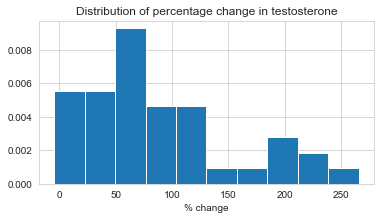

In [4]:
plt.hist(100*m_df[m_df['Test']==1].TPl_change, density=True); plt.title('Distribution of percentage change in testosterone');
plt.xlabel('% change');

## Utility function for gap estimation
From cpt theory: theano version for pyMC3 estimation


In [5]:
def value_f(x, alpha):
    """
    the power value function suggested by Tversky and Kahneman (1992)
    @param x: float, positive, money
    @param alpha: float, expected to be less then 1     
    """
    #val = tt.switch(tt.lt(x, 0),-tt.pow(-x, alpha),tt.pow(x, alpha))
    val  = tt.sgn(x)*tt.pow(tt.abs_(x),alpha)
    return val


def weights(p,c):
    """
    one-parameter weighting function used in Nilsson  
    @param p: float, real probability of gain or loss, should be in the interval (0,1) 
    @param c: float,the elevation of the weighting function, should be positive, expected in the interval (0,5)     
    @return: float, subjective probability of gain or loss, should be in the interval (0,1) 
    """
    numer = tt.pow(p,c)
    denom = tt.pow(tt.pow(p,c) + tt.pow(1-p,c),1/c)
    return numer/denom

def weights_numpy(p,c):
    """
    one-parameter weighting function used in Nilsson
    
    @param p: float, real probability of gain or loss, should be in the interval (0,1) 
    @param c: float,the elevation of the weighting function, should be positive, expected in the interval (0,5) 
    @return: float, subjective probability of gain or loss, should be in the interval (0,1) 
    """
    numer = np.power(p,c)
    denom = np.power(np.power(p,c) + np.power(1-p,c),1/c)
    return numer/denom
def value_numpy(x,alpha):
    return np.sign(x)*np.abs(x)**alpha
def gap(A, B, p, alpha, c):
    """
    Here for loss we also have positive values, so need to multiply gap value to -1 later
    
    compute subjective difference between two options: A (game), B (sure)
    @param A: float, positive, money, risk value
    @param B: float, positive, money, sure option
    @param alpha: float, expected to be less then 1  
    """
    val = value_f(A, alpha)*weights(p,c) - value_f(B, alpha)
    return val

## Models estimation

toDo: actualize models with the list below


 - model 0:  Only 1: win and 0:los (ignoring testosterone condition). The only model where we estimated CPT parameters from the data
 
$$y_i \sim Binomial(1, p_i)$$
$$\theta = logit(p_i)  = \alpha_{cond} + \beta_{cond}*gap(A,B,alpha,c)$$
$$\alpha_{cond} = Normal(0,1, shape = 2)$$

$$\beta_{cond} = BoundedNormal(0.4,0.5, shape = 2)$$

 - model 1: 4 conditions 0: Win(Placebo), 1: Win(Test),2: Loss(Placebo), 3: Loss(Test)
 
 $$y_i \sim Binomial(1, p_i)$$
$$\theta = logit(p_i)  = \alpha_{cond} + \beta_{cond}*gap(A,B,alpha,c)$$
$$\alpha_{cond} = Normal(0,1, shape = 4)$$

$$\beta_{cond} = BoundedNormal(0.4,0.5, shape = 4)$$


### Model evaluation functions

For model quality evaluation we used:
 - posterior predictive checks: how well model explain the same data from the model. In our case we used two scorings: roc_auc_score, and $R^2$ for regression between real choise and predictions at the group level 

 - WAIC (widely applicable information criterion)

In [6]:
def est_model_group(trace, model, df=None):
    est_df = df.copy()   
    ppc = pm.sample_posterior_predictive(trace, samples=500, model=model)
    beta = st.beta((ppc['Strg'] == 1).sum(axis=0), (ppc['Strg'] == 0).sum(axis=0))
    est_df['Pred_lb'] = beta.interval(0.95)[0]
    est_df['Pred_ub'] = beta.interval(0.95)[1]
    est_df['Pred'] = ppc['Strg'].mean(axis=0)
    res = est_df.groupby('GameId')[['Pred','Strategy']].mean()

    res = est_df.groupby('GameId')[['Pred','Strategy', 'Pred_lb', 'Pred_ub']].mean()
    errs = (res['Pred_lb'].values.T,res['Pred_ub'].values.T)

    plt.plot(res.Strategy, res.Pred,'*',[0,1],[0,1]);
    plt.vlines(res.Strategy, *errs, colors='gray')
    
    regressor = LinearRegression(fit_intercept=False)
    regressor.fit(res.Strategy.values.reshape(-1,1), res.Pred.values.reshape(-1,1))
    print(f'R^2 value for real and predicted data: {regressor.score(res.Strategy.values.reshape(-1,1), res.Pred.values.reshape(-1,1)):.2f}')
    score = roc_auc_score(m_df.Strategy, ppc['Strg'].mean(axis = 0))
    print(f'ROC_AUC score for real and predicted data: {score:.2f}')

    #plt.show()
    return est_df

### Model 0: Original CPT model without shift and logarithmic transform


In [7]:
chains = 4
N = len(pd.unique(m_df.Inds))

with pm.Model() as model_0:
    """
    model without any individual distinctions, without testosterone. Estimation CPT model from the data
    """    
    BoundedNormalI = pm.Bound(pm.Normal, lower=0.0, upper = 1.0)
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    
    alpha = BoundedNormalI('alpha',mu = 0.75, sd=0.5, shape = 2)
    c = BoundedNormalI('c', mu = 0.79, sd = 0.5, shape = 2)
    beta = BoundedNormal('beta', 0.5,1, shape = 2)

    Gap = gap(m_df.A, m_df.B, m_df.P, alpha[m_df.Win.values], c[m_df.Win.values]) 

    theta = pm.math.invlogit(beta[m_df.Win.values]*Gap)
   
    strategy = pm.Bernoulli("Strg", p=theta, observed=m_df.Strategy)

    trace_0 = pm.sample(2000, tune=500, target_accept=0.95, chains=chains, init = 'advi')[500:]
    model0 = az.from_pymc3(trace=trace_0)
    model0.to_netcdf("models/Model_0.nc");    

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 486.79:   8%|▊         | 15999/200000 [00:08<01:42, 1788.55it/s]
Convergence achieved at 16000
Interrupted at 15,999 [7%]: Average Loss = 1,116.6
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, c, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:27<00:00, 362.62draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [78]:

trace_0 = az.from_netcdf(os.path.join('models', "Model_0.nc"))
az.waic(trace_0)

Computed from 6000 by 800 log-likelihood matrix

          Estimate       SE
elpd_waic  -424.88    13.98
p_waic        3.95        -

In [9]:
az.summary(trace_0,credible_interval=.89, round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.97,0.03,0.93,1.00,0.00,0.00,4583.10,4505.73,2886.77,1834.81,1.0
alpha[1],0.36,0.09,0.23,0.50,0.00,0.00,800.59,800.59,829.10,934.25,1.0
c[0],0.88,0.07,0.79,1.00,0.00,0.00,3464.77,3275.17,2944.87,2150.58,1.0
c[1],0.95,0.04,0.90,1.00,0.00,0.00,2178.24,2148.03,1726.82,1580.74,1.0
beta[0],0.00,0.00,0.00,0.01,0.00,0.00,5249.34,5249.34,4772.83,4503.95,1.0
beta[1],0.59,0.26,0.26,0.93,0.01,0.01,750.03,740.75,832.48,931.13,1.0


In negative framing sensitivity equal to 0, what means random guess

/Users/irinaknyazeva/opt/anaconda3/envs/py36/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:00<00:00, 976.65it/s]


R^2 value for real and predicted data: 0.63
ROC_AUC score for real and predicted data: 0.74


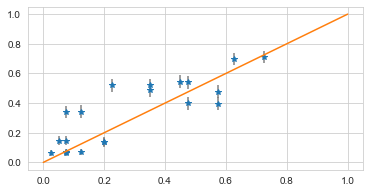

In [10]:
est = est_model_group(trace_0, model_0, m_df);

### Model 1: CPT model with shift and logarithmic transform

In [11]:
chains = 4
N = len(pd.unique(m_df.Inds))

with pm.Model() as model_1:
    """
    model without any individual distinctions, without testosterone
    """
    
    BoundedNormalI = pm.Bound(pm.Normal, lower=0.0, upper = 1.0)
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    alpha = BoundedNormalI('alpha',mu = 0.75, sd=0.5, shape = 2)
    c = BoundedNormalI('c', mu = 0.79, sd = 0.5, shape = 2)
    beta = BoundedNormal('beta', 0.9,1, shape = 2)
    a = pm.Normal('a', 0, 1, shape = 2)
    

    Gap = gap(m_df.A, m_df.B, m_df.P, alpha[m_df.Win.values], c[m_df.Win.values]) #[m_df.Win.values]
    Gap = tt.sgn(Gap)*tt.log(1+tt.abs_(Gap))
    
    theta = pm.math.invlogit(a[m_df.Win.values]+beta[m_df.Win.values]*Gap)
   
    strategy = pm.Bernoulli("Strg", p=theta, observed=m_df.Strategy)
    trace_1 = pm.sample(2000, tune=500, target_accept=0.95, chains=chains, init = 'advi')[500:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 435.89:   7%|▋         | 13499/200000 [00:07<01:43, 1808.39it/s]
Convergence achieved at 13500
Interrupted at 13,499 [6%]: Average Loss = 523.8
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, beta, c, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [02:01<00:00, 82.26draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [12]:
az.waic(trace_1)

Computed from 6000 by 800 log-likelihood matrix

          Estimate       SE
elpd_waic  -407.62    14.36
p_waic        6.21        -

In [13]:
az.summary(trace_1,credible_interval=.89, round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-1.61,0.73,-2.70,-0.71,0.04,0.03,272.92,272.92,305.24,2057.19,1.01
a[1],-0.46,0.98,-1.56,1.11,0.14,0.10,47.25,47.25,75.66,326.87,1.07
alpha[0],0.61,0.35,0.19,1.00,0.02,0.02,230.69,225.99,289.75,1089.24,1.01
alpha[1],0.69,0.25,0.30,1.00,0.03,0.02,53.36,53.36,66.22,643.93,1.06
c[0],0.90,0.08,0.80,1.00,0.00,0.00,1532.95,1496.15,1419.63,1617.01,1.00
c[1],0.89,0.07,0.79,1.00,0.00,0.00,937.60,909.65,931.60,1752.28,1.00
beta[0],0.96,0.88,0.16,2.27,0.05,0.04,308.40,308.40,302.23,2088.74,1.01
beta[1],0.87,0.84,0.19,2.19,0.13,0.09,43.21,43.21,69.60,503.71,1.06


/Users/irinaknyazeva/opt/anaconda3/envs/py36/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:00<00:00, 503.68it/s]


R^2 value for real and predicted data: 0.82
ROC_AUC score for real and predicted data: 0.77


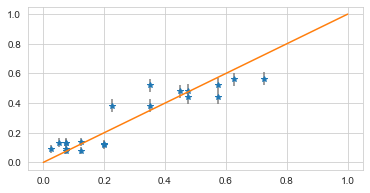

In [14]:
est = est_model_group(trace_1, model_1, m_df);

### Model 2:  with fixed alpha and c from replication study

From replication study  (see notebook Rieksamp_replication.ipynb)
$$\alpha = 0.756 \pm 0.033$$  
$$c = 0.794 \pm 0.022 $$

In [15]:
chains = 4

with pm.Model() as model_2:
    """
    model without any individual distinctions, without testosterone
    """
    #try with fixed value of alpha
    
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    
    alpha = 0.75
    c = 0.8
    
    beta = BoundedNormal('beta', 0.5,1, shape = 2)
    a = pm.Normal('a', 0, 1, shape = 2)
    
    Gap = gap(m_df.A, m_df.B, m_df.P, alpha, c) 
    Gap = tt.sgn(Gap)*tt.log(1+tt.abs_(Gap))
    
    theta = pm.math.invlogit(a[m_df.Win.values]+beta[m_df.Win.values]*Gap)
   
    strategy = pm.Bernoulli("Strg", p=theta, observed=m_df.Strategy)
    trace_2 = pm.sample(2000, tune=500, target_accept=0.95, chains=chains, init = 'advi')[500:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 420.84:   5%|▍         | 9799/200000 [00:04<01:32, 2045.51it/s]
Convergence achieved at 9800
Interrupted at 9,799 [4%]: Average Loss = 518.25
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, beta]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:04<00:00, 2146.64draws/s]


/Users/irinaknyazeva/opt/anaconda3/envs/py36/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:00<00:00, 1131.94it/s]


R^2 value for real and predicted data: 0.76
ROC_AUC score for real and predicted data: 0.76


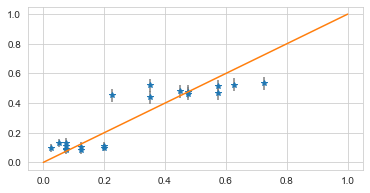

In [16]:
est = est_model_group(trace_2, model_2, m_df);

In [17]:
az.waic(trace_2)

Computed from 6000 by 800 log-likelihood matrix

          Estimate       SE
elpd_waic  -410.57    14.50
p_waic        4.15        -

In [18]:
az.summary(trace_2,credible_interval=.89, round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-1.14,0.15,-1.38,-0.91,0.0,0.0,4151.10,4101.74,4164.55,3513.94,1.0
a[1],-0.90,0.13,-1.11,-0.70,0.0,0.0,5021.41,4846.08,5025.73,3967.46,1.0
beta[0],0.30,0.04,0.24,0.37,0.0,0.0,3834.56,3834.56,3822.83,3654.27,1.0
beta[1],0.42,0.05,0.33,0.50,0.0,0.0,5165.51,5165.51,5141.92,3661.59,1.0


### Model 3:  with fixed alpha and c from replication study, and 4 conditions

In [19]:
chains = 2
N = len(pd.unique(m_df.Inds))

with pm.Model() as model_3:
    """
    model without any individual distinctions, with hormones
    """
    #try with fixed value of alpha
    
    BoundedNormalI = pm.Bound(pm.Normal, lower=0.0, upper = 1.0)
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    
    alpha = 0.75
    c = 0.8

    a = pm.Normal('a', 0, 1, shape = 4)
    beta = BoundedNormal('beta', 0.5,0.5, shape = 4)
    
    Gap = gap(m_df.A, m_df.B, m_df.P, alpha, c) 
    Gap = tt.sgn(Gap)*tt.log(1+tt.abs_(Gap))
    
    theta = pm.math.invlogit(a[m_df.TypeCode.values]+beta[m_df.TypeCode.values]*Gap)
   
    strategy = pm.Binomial("Strg", 1, p=theta, observed=m_df.Strategy)
    trace_3 = pm.sample(2000, tune=500, target_accept=0.95, chains=chains, init = 'advi')[500:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 424.21:   5%|▍         | 9499/200000 [00:03<01:07, 2827.96it/s]
Convergence achieved at 9500
Interrupted at 9,499 [4%]: Average Loss = 529.62
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:06<00:00, 760.27draws/s] 


In [20]:
az.waic(trace_3)

Computed from 3000 by 800 log-likelihood matrix

          Estimate       SE
elpd_waic  -411.61    14.80
p_waic        8.13        -

In [21]:
az.summary(trace_3, credible_interval=.75, round_to=2)

,mean,sd,hpd_12.5%,hpd_87.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-1.03,0.17,-1.23,-0.83,0.0,0.0,3826.45,3626.46,3846.21,2302.23,1.0
a[1],-0.77,0.18,-0.98,-0.56,0.0,0.0,2966.05,2816.97,2967.93,2406.54,1.0
a[2],-1.06,0.20,-1.26,-0.80,0.0,0.0,2205.88,2140.16,2213.87,2064.51,1.0
a[3],-1.21,0.21,-1.45,-0.98,0.0,0.0,1949.02,1868.45,1990.86,1747.04,1.0
beta[0],0.33,0.08,0.24,0.41,0.0,0.0,2221.97,2221.97,2134.56,1376.40,1.0
beta[1],0.52,0.08,0.42,0.61,0.0,0.0,2800.71,2800.71,2726.65,2127.48,1.0
beta[2],0.32,0.06,0.25,0.38,0.0,0.0,2165.64,2142.44,2175.40,1920.18,1.0
beta[3],0.29,0.06,0.23,0.36,0.0,0.0,1789.60,1779.45,1788.68,1836.70,1.0


/Users/irinaknyazeva/opt/anaconda3/envs/py36/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:00<00:00, 675.60it/s]


R^2 value for real and predicted data: 0.81
ROC_AUC score for real and predicted data: 0.76


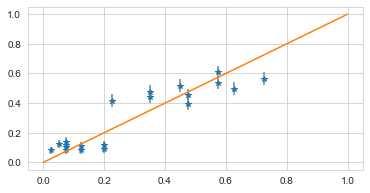

In [22]:
est = est_model_group(trace_3, model_3, m_df);

### Model 4: reparametrization: additional testosterone effect
The same model as previous, but parameterized with additional effect of testosterone

In [23]:
chains = 2
N = len(pd.unique(m_df.Inds))

with pm.Model() as model_4:
    """
    model without any individual distinctions, with hormones
    """
    
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    
    alpha = 0.75
    c = 0.8

    a = pm.Normal('a', 0, 1, shape = 2)
    beta = BoundedNormal('beta', 0.5,0.5, shape = 2)
    delta_a = pm.Normal('delta_a', 0, 0.5, shape = 2)
    delta_b = pm.Normal('delta_b', 0, 0.5, shape = 2)

    Gap = gap(m_df.A, m_df.B, m_df.P, alpha, c) 
    Gap = tt.sgn(Gap)*tt.log(1+tt.abs_(Gap))
    theta_lin = a[m_df.Win.values]+delta_a[m_df.Win.values]*m_df.Test.values+(beta[m_df.Win.values]+delta_b[m_df.Win.values]*m_df.Test.values)*Gap
    
    theta = pm.math.invlogit(theta_lin)
   
    strategy = pm.Binomial("Strg", 1, p=theta, observed=m_df.Strategy)
    trace_4 = pm.sample(2000, tune=500, target_accept=0.95, chains=chains, init = 'advi')[500:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 421.91:   7%|▋         | 14999/200000 [00:09<01:55, 1597.74it/s]
Convergence achieved at 15000
Interrupted at 14,999 [7%]: Average Loss = 516.55
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [delta_b, delta_a, beta, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:12<00:00, 411.35draws/s]


In [24]:
az.waic(trace_4)

Computed from 3000 by 800 log-likelihood matrix

          Estimate       SE
elpd_waic  -411.14    14.89
p_waic        7.67        -

In [25]:
az.summary(trace_4,credible_interval=.75, round_to=2)

,mean,sd,hpd_12.5%,hpd_87.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-1.08,0.19,-1.28,-0.84,0.00,0.0,1586.62,1536.95,1588.99,1409.81,1.0
a[1],-1.01,0.16,-1.20,-0.83,0.00,0.0,2442.74,2442.74,2454.43,1927.88,1.0
delta_a[0],-0.16,0.26,-0.43,0.16,0.01,0.0,1641.87,1600.20,1642.87,1806.21,1.0
delta_a[1],0.19,0.22,-0.06,0.44,0.00,0.0,2342.64,2032.92,2348.01,2071.98,1.0
delta_b[0],-0.03,0.08,-0.13,0.05,0.00,0.0,1765.04,1563.74,1770.55,1918.79,1.0
delta_b[1],0.19,0.11,0.05,0.30,0.00,0.0,2031.60,1490.60,2038.28,1553.08,1.0
beta[0],0.33,0.06,0.25,0.38,0.00,0.0,1517.06,1517.06,1516.80,1656.77,1.0
beta[1],0.33,0.07,0.25,0.41,0.00,0.0,1875.01,1875.01,1881.68,1464.95,1.0


/Users/irinaknyazeva/opt/anaconda3/envs/py36/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:00<00:00, 613.36it/s]


R^2 value for real and predicted data: 0.81
ROC_AUC score for real and predicted data: 0.76


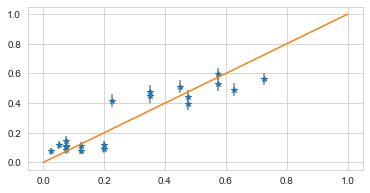

In [26]:
est = est_model_group(trace_4, model_4, m_df);

### Model 5. Modification with the level of percentage changes

In [27]:
chains = 2
N = len(pd.unique(m_df.Inds))

with pm.Model() as model_5:
    """
    model without any individual distinctions, with hormones
    """
    
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    
    alpha = 0.75
    c = 0.8

    a = pm.Normal('a', 0, 1, shape = 2)
    beta = BoundedNormal('beta', 0.5,0.5, shape = 2)
    delta_a = pm.Normal('delta_a', 0, 0.5, shape = 2)
    delta_b = pm.Normal('delta_b', 0, 0.5, shape = 2)

 
    Gap = gap(m_df.A, m_df.B, m_df.P, alpha, c) 
    Gap = tt.sgn(Gap)*tt.log(1+tt.abs_(Gap))
    theta_lin = a[m_df.Win.values]+delta_a[m_df.Win.values]*m_df.TPl_change.values+(beta[m_df.Win.values]+delta_b[m_df.Win.values]*m_df.TPl_change.values)*Gap
    
    theta = pm.math.invlogit(theta_lin)
   
    strategy = pm.Binomial("Strg", 1, p=theta, observed=m_df.Strategy)
    trace_5 = pm.sample(2000, tune=500, target_accept=0.95, chains=chains, init = 'advi')[500:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 421.21:   7%|▋         | 14599/200000 [00:09<01:54, 1619.84it/s]
Convergence achieved at 14600
Interrupted at 14,599 [7%]: Average Loss = 522.2
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [delta_b, delta_a, beta, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:10<00:00, 459.21draws/s]


In [28]:
az.waic(trace_5)

/Users/irinaknyazeva/opt/anaconda3/envs/py36/lib/python3.6/site-packages/arviz/stats/stats.py:1210: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 3000 by 800 log-likelihood matrix

          Estimate       SE
elpd_waic  -410.00    14.75
p_waic        7.44        -

There has been a warning during the calculation. Please check the results.

In [29]:
az.summary(trace_5,credible_interval=.75, round_to=2)

,mean,sd,hpd_12.5%,hpd_87.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.99,0.17,-1.16,-0.78,0.00,0.0,2410.74,2378.66,2413.30,2259.93,1.0
a[1],-0.93,0.15,-1.08,-0.75,0.00,0.0,2760.56,2680.77,2755.18,1814.03,1.0
delta_a[0],-0.48,0.25,-0.71,-0.13,0.01,0.0,1875.52,1629.99,1931.56,1629.33,1.0
delta_a[1],0.03,0.20,-0.19,0.26,0.00,0.0,2569.78,1804.13,2587.28,2173.82,1.0
delta_b[0],0.06,0.08,-0.03,0.14,0.00,0.0,1839.24,1416.29,1870.64,1805.46,1.0
delta_b[1],0.15,0.09,0.04,0.24,0.00,0.0,2409.60,1974.58,2461.58,2076.68,1.0
beta[0],0.29,0.05,0.24,0.34,0.00,0.0,2102.16,2102.16,2082.43,2132.29,1.0
beta[1],0.36,0.06,0.30,0.43,0.00,0.0,1963.63,1963.63,1977.68,1529.72,1.0


### Model 6: Four condition model and individual differences

In [30]:
chains = 2
N = len(pd.unique(m_df.Inds))

with pm.Model() as model_6:
    """
    model without any individual distinctions, with hormones
    """
    
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    
    alpha = 0.75
    c = 0.8
    a = pm.Normal('a', 0, 1, shape = 4)
    beta = BoundedNormal('beta', 0.5,0.5, shape = 4)
    alpha_ind = pm.Normal('alpha_ind', 0, 0.5,shape = 40)
    beta_ind = pm.Normal('beta_ind', 0, 0.2, shape = 40)
    

    Gap = gap(m_df.A, m_df.B, m_df.P, alpha, c) 
    Gap = tt.sgn(Gap)*tt.log(1+tt.abs_(Gap))
    
    theta = pm.math.invlogit(alpha_ind[m_df.Inds.values]+a[m_df.TypeCode.values]+(beta_ind[m_df.Inds.values]+beta[m_df.TypeCode.values])*Gap)

    strategy = pm.Binomial("Strg", 1, p=theta, observed=m_df.Strategy)
    #strategy = pm.Bernoulli("Strg", p=theta, observed=m_df.Strategy)

    trace_6 = pm.sample(5000, tune=1000, target_accept=0.95, chains=chains, init = 'advi')[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 388.8:   6%|▌         | 12199/200000 [00:07<01:54, 1642.36it/s] 
Convergence achieved at 12200
Interrupted at 12,199 [6%]: Average Loss = 550.66
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta_ind, alpha_ind, beta, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 12000/12000 [00:21<00:00, 558.58draws/s]


In [31]:
az.waic(trace_6)

/Users/irinaknyazeva/opt/anaconda3/envs/py36/lib/python3.6/site-packages/arviz/stats/stats.py:1210: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 8000 by 800 log-likelihood matrix

          Estimate       SE
elpd_waic  -352.40    14.58
p_waic       37.04        -

There has been a warning during the calculation. Please check the results.

In [32]:
az.summary(trace_6, var_names = ['a','beta'],credible_interval=.75, round_to=2)

,mean,sd,hpd_12.5%,hpd_87.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-1.13,0.20,-1.36,-0.90,0.0,0.0,9755.10,9421.00,9757.71,5773.00,1.0
a[1],-0.81,0.21,-1.05,-0.57,0.0,0.0,9845.67,9519.35,9809.57,6026.38,1.0
a[2],-1.18,0.23,-1.44,-0.91,0.0,0.0,6886.79,6646.45,6951.05,6143.13,1.0
a[3],-1.36,0.23,-1.61,-1.08,0.0,0.0,6850.76,6548.17,6970.31,5610.45,1.0
beta[0],0.37,0.08,0.27,0.47,0.0,0.0,5815.34,5815.34,5731.92,3702.47,1.0
beta[1],0.58,0.09,0.48,0.68,0.0,0.0,8703.33,8703.33,8622.67,5894.33,1.0
beta[2],0.37,0.07,0.30,0.45,0.0,0.0,4874.03,4874.03,4805.77,4545.06,1.0
beta[3],0.34,0.07,0.25,0.41,0.0,0.0,5037.37,5037.37,4953.55,4836.31,1.0


/Users/irinaknyazeva/opt/anaconda3/envs/py36/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:00<00:00, 1018.74it/s]


R^2 value for real and predicted data: 0.81
ROC_AUC score for real and predicted data: 0.89


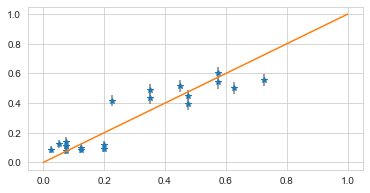

In [33]:
est = est_model_group(trace_6, model_6, m_df);

### Model 7: Individual differences and additional parameters for testosterone

In [34]:
chains = 2
N = len(pd.unique(m_df.Inds))

with pm.Model() as model_7:
    """
    model without any individual distinctions, with hormones
    """
    
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    
    alpha = 0.75
    c = 0.8
    a = pm.Normal('a', 0, 1, shape = 2)
    beta = BoundedNormal('beta', 0.5,0.5, shape = 2)
    delta_a = pm.Normal('delta_a', 0, 0.5, shape = 2)
    delta_b = pm.Normal('delta_b', 0, 0.5, shape = 2)

    alpha_ind = pm.Normal('alpha_ind', 0, 0.5,shape = 40)
    beta_ind = pm.Normal('beta_ind', 0, 0.2, shape = 40)
    

    Gap = gap(m_df.A, m_df.B, m_df.P, alpha, c) 
    Gap = tt.sgn(Gap)*tt.log(1+tt.abs_(Gap))
    
    theta_lin = alpha_ind[m_df.Inds.values]+a[m_df.Win.values]+delta_a[m_df.Win.values]*m_df.TPl_change.values+\
                (beta_ind[m_df.Inds.values]+ beta[m_df.Win.values]+delta_b[m_df.Win.values]*m_df.TPl_change.values)*Gap

    theta = pm.math.invlogit(theta_lin)


    strategy = pm.Binomial("Strg", 1, p=theta, observed=m_df.Strategy)
    #strategy = pm.Bernoulli("Strg", p=theta, observed=m_df.Strategy)

    trace_7 = pm.sample(2000, tune=500, target_accept=0.95, chains=chains, init = 'advi')[500:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 387.14:   7%|▋         | 13899/200000 [00:05<01:18, 2362.35it/s]
Convergence achieved at 13900
Interrupted at 13,899 [6%]: Average Loss = 558.33
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta_ind, alpha_ind, delta_b, delta_a, beta, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:10<00:00, 482.89draws/s]


In [35]:
az.waic(trace_7)

/Users/irinaknyazeva/opt/anaconda3/envs/py36/lib/python3.6/site-packages/arviz/stats/stats.py:1210: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 3000 by 800 log-likelihood matrix

          Estimate       SE
elpd_waic  -351.87    14.68
p_waic       36.83        -

There has been a warning during the calculation. Please check the results.

/Users/irinaknyazeva/opt/anaconda3/envs/py36/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:00<00:00, 924.77it/s]


R^2 value for real and predicted data: 0.80
ROC_AUC score for real and predicted data: 0.89


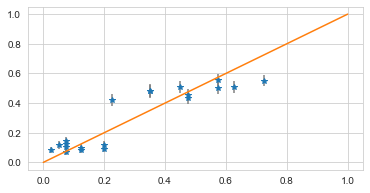

In [36]:
est = est_model_group(trace_7, model_7, m_df);

In [37]:
az.summary(trace_7, var_names = ['a','beta', 'delta_a','delta_b'],credible_interval=.75, round_to=2)

,mean,sd,hpd_12.5%,hpd_87.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-1.14,0.20,-1.34,-0.89,0.00,0.0,1965.02,1963.63,1966.40,2152.52,1.0
a[1],-1.04,0.18,-1.24,-0.83,0.00,0.0,1849.56,1827.66,1860.76,1921.17,1.0
beta[0],0.35,0.06,0.29,0.42,0.00,0.0,1270.52,1270.52,1261.12,1475.85,1.0
beta[1],0.41,0.07,0.33,0.50,0.00,0.0,1765.31,1765.31,1761.91,1589.49,1.0
delta_a[0],-0.49,0.26,-0.81,-0.21,0.01,0.0,1858.79,1703.39,1861.23,1966.52,1.0
delta_a[1],0.08,0.21,-0.14,0.34,0.00,0.0,2749.16,2008.42,2744.52,2505.81,1.0
delta_b[0],0.04,0.08,-0.06,0.12,0.00,0.0,1885.28,1862.27,1908.94,2238.70,1.0
delta_b[1],0.16,0.10,0.03,0.25,0.00,0.0,3160.53,2535.51,3198.98,2483.01,1.0


## Testosterone-related parameters 

In [38]:
def plot_deltas(trace):

    fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)
    for i in [0,1]:
        az.plot_posterior(trace['delta_a'][:, i], ref_val=0, ax = ax[i])
    fig.suptitle(f" Testosterone-related sure-option shift for Negative framing (left) and Positive (right)", fontsize=16);
    fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)
    for i in [0,1]:
        az.plot_posterior(trace['delta_b'][:, i], ref_val=0, ax = ax[i])
    fig.suptitle(f" Testosterone-related sensitivity to gap for Negative framing (left) and Positive (right)", fontsize=16);
    
def plot_4cond(trace):   
    
    az.plot_forest(trace, var_names = ['a'], kind = 'ridgeplot', figsize=(4,5), colors='purple', ridgeplot_overlap=3);
    az.plot_forest(trace, var_names = ['beta'], kind = 'ridgeplot', figsize=(4,5), colors='#eeefff', ridgeplot_overlap=3);

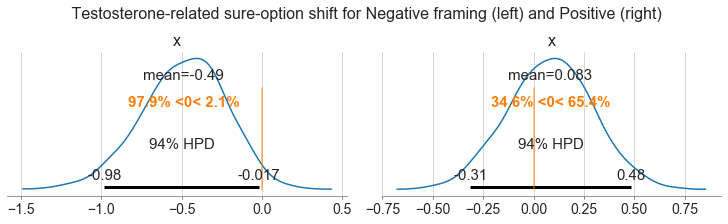

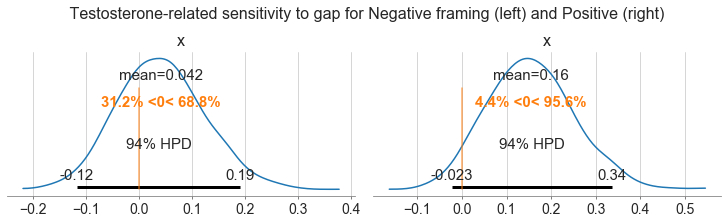

In [39]:
plot_deltas(trace_7)

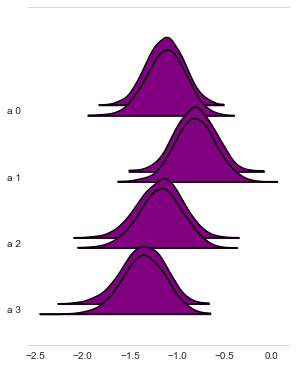

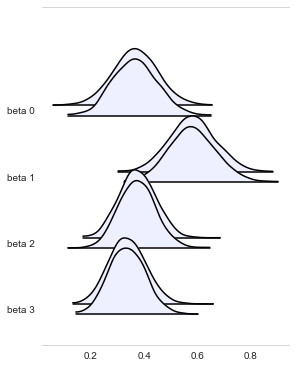

In [40]:
plot_4cond(trace_6)

## Effect analysis

### Risk sensitivity to the percentage change in testosteron level with the fixed gaps

In [41]:
def risk_sens_testn(trace, tchange = np.linspace(0,3,30), cr_int = 0.5, gaps = [1,3,5]):
    plt.figure(figsize = (15,6))

    #ind = 0 (Negative),1 (Positive)
    a_mu = trace['a'].mean(axis=0)
    a_bounds = az.hpd(trace['a'], credible_interval=cr_int)
    beta_mu = trace['beta'].mean(axis=0)
    beta_bounds = az.hpd(trace['beta'],credible_interval=cr_int)
    delta_a_mu = trace['delta_a'].mean(axis=0)
    delta_a_bounds = az.hpd(trace['delta_a'],credible_interval=cr_int)
    delta_b_mu = trace['delta_b'].mean(axis=0)
    delta_b_bounds = az.hpd(trace['delta_b'],credible_interval=cr_int)
    
    def theta_errs(ind, gap):
        theta = invlogit(a_mu[ind]+delta_a_mu[ind]*tchange+(beta_mu[ind]+delta_b_mu[ind]*tchange)*gap)
        theta_lb = invlogit(a_bounds[ind,0]+delta_a_bounds[ind,0]*tchange+(delta_b_bounds[ind,0]*tchange+beta_bounds[ind,0])*gap)
        theta_ub = invlogit(a_bounds[ind,1]+delta_a_bounds[ind,1]*tchange+(delta_b_bounds[ind,1]*tchange+beta_bounds[ind,1])*gap)
        return theta, theta_lb, theta_ub

    plt.suptitle(f'Willingness to risk depending on the testosteron level and potenial gain', fontsize = 20)

    colors=cm.plasma(np.linspace(0,0.6,len(gaps)))

    plt.subplot(1,2,1); 
    for gap, c in zip(gaps,colors):
        theta_W, theta_W_lb, theta_W_ub = theta_errs(1,gap)
        plt.plot(tchange, theta_W, color=c, label = f'Gain: {np.expm1(gap):.0f}'); plt.ylim(0,1); plt.legend()
        plt.vlines(tchange, theta_W_lb,theta_W_ub, colors = c, alpha=0.4)
    
    plt.ylabel('Probability to choose Risk option')
    plt.xlabel('Change iin testosterone level compared to placebo states')
    plt.title('Positive framing', size = 16)
    plt.legend()
    
    
    plt.subplot(1,2,2); 
    for gap, c in zip(gaps,colors):
        theta_W, theta_W_lb, theta_W_ub = theta_errs(0,gap)
        plt.plot(tchange, theta_W, label = f'Gain: {np.expm1(gap):.0f}', color=c); plt.ylim(0,1); plt.legend()
        plt.vlines(tchange, theta_W_lb,theta_W_ub, colors=c,alpha=0.4)
    
    plt.ylabel('Probability to choose Risk option')
    plt.xlabel('Change iin testosterone level compared to placebo states')
    plt.title('Negative framing', size = 16)
    plt.legend()
    return theta_W, theta_W_lb, theta_W_ub

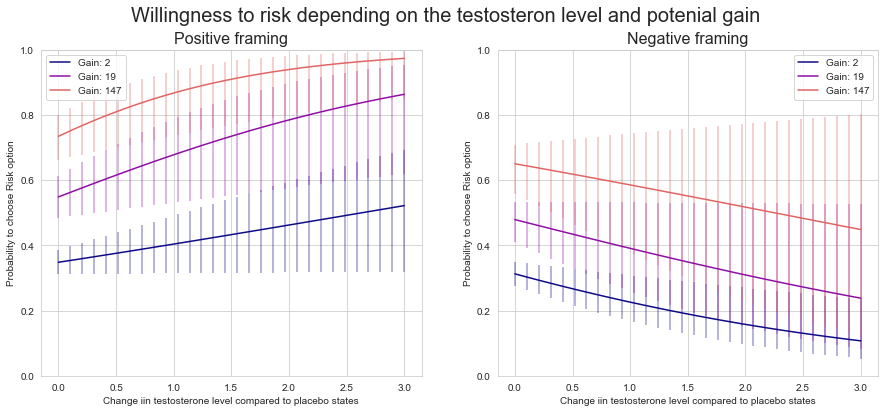

In [42]:
theta_W, theta_W_lb, theta_W_ub = risk_sens_testn(trace_7)

### Willingness to risk depending on the gap with several level of testosteron changes

In [43]:
def gap_sens_testn(trace, gaps = np.linspace(0,5,50), cr_int = 0.5, testn = [0,0.6,1.5]):
    plt.figure(figsize = (15,6))

    a_mu = trace['a'].mean(axis=0)
    a_bounds = az.hpd(trace['a'], credible_interval=cr_int)
    beta_mu = trace['beta'].mean(axis=0)
    beta_bounds = az.hpd(trace['beta'],credible_interval=cr_int)
    delta_a_mu = trace['delta_a'].mean(axis=0)
    delta_a_bounds = az.hpd(trace['delta_a'],credible_interval=cr_int)
    delta_b_mu = trace['delta_b'].mean(axis=0)
    delta_b_bounds = az.hpd(trace['delta_b'],credible_interval=cr_int)
    
    def theta_errs(ind, test):
        theta = invlogit(a_mu[ind]+delta_a_mu[ind]*test+(beta_mu[ind]+delta_b_mu[ind]*test)*gaps)
        theta_lb = invlogit(a_bounds[ind,0]+delta_a_bounds[ind,0]*test+(delta_b_bounds[ind,0]*test+beta_bounds[ind,0])*gaps)
        theta_ub = invlogit(a_bounds[ind,1]+delta_a_bounds[ind,1]*test+(delta_b_bounds[ind,1]*test+beta_bounds[ind,1])*gaps)
        return theta, theta_lb, theta_ub

    plt.suptitle(f'Willingness to risk depending on the testosteron level and potenial gain', fontsize = 20)

    colors=cm.plasma(np.linspace(0,0.6,len(testn)))

    plt.subplot(1,2,1); 
    for test, c in zip(testn,colors):
        theta_W, theta_W_lb, theta_W_ub = theta_errs(1,test)
        plt.plot(np.expm1(gaps), theta_W, color=c, label = f'ChangeTest: {100*test:.0f}'); plt.ylim(0,1); plt.legend()
        plt.vlines(np.expm1(gaps), theta_W_lb,theta_W_ub, colors = c, alpha=0.4)
    
    plt.ylabel('Probability to choose Risk option')
    plt.xlabel('Change iin testosterone level compared to placebo states')
    plt.title('Positive framing', size = 16)
    plt.legend()
    
    
    plt.subplot(1,2,2); 
    for test, c in zip(testn,colors):
        theta_W, theta_W_lb, theta_W_ub = theta_errs(0,test)
        plt.plot(np.expm1(gaps), theta_W, label = f'ChangeTest: {100*test:.0f}', color=c); plt.ylim(0,1); plt.legend()
        plt.vlines(np.expm1(gaps), theta_W_lb,theta_W_ub, colors=c,alpha=0.4)
    
    plt.ylabel('Probability to choose Risk option')
    plt.xlabel('Change iin testosterone level compared to placebo states')
    plt.title('Negative framing', size = 16)
    plt.legend()


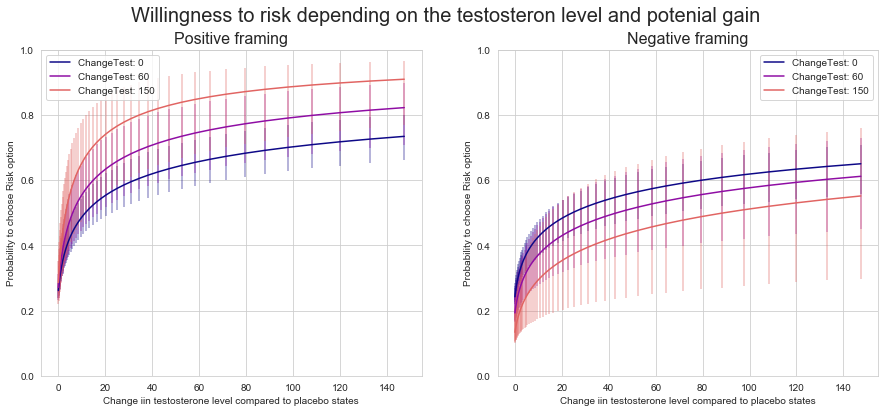

In [44]:
gap_sens_testn(trace_7)

### Risk sensitivity to gain (binary outcome: Place, Testosteronr)

In [45]:
def risk_sens_gain(trace, gaps, cr_int = 0.7):
    plt.figure(figsize = (15,6))
    
    alpha_bounds = az.hpd(trace['a'], credible_interval=cr_int)
    alpha_mu = trace['a'].mean(axis=0)
    beta_bounds = az.hpd(trace['beta'],credible_interval=cr_int)
    beta_mu = trace['beta'].mean(axis=0)
    
    def theta_errs(ind):
        theta = invlogit(alpha_mu[ind]+beta_mu[ind]*gaps)
        theta_lb = invlogit(alpha_bounds[ind,0]+beta_bounds[ind,0]*gaps)
        theta_ub = invlogit(alpha_bounds[ind,1]+beta_bounds[ind,1]*gaps)
        return theta, theta_lb, theta_ub
    
    plt.suptitle('Willingness to risk depending on the potential gain', fontsize = 20)

    theta_W_PL, theta_W_Pl_lb, theta_W_Pl_ub = theta_errs(0)
    plt.subplot(1,2,1); plt.plot(np.expm1(gaps), theta_W_PL, label = 'Placebo'); plt.ylim(0,1); plt.legend()
    plt.vlines(np.expm1(gaps), theta_W_Pl_lb,theta_W_Pl_ub, colors='black', alpha=0.5)

    theta_W_T, theta_W_T_lb, theta_W_T_ub = theta_errs(1)
    plt.subplot(1,2,1);plt.plot(np.expm1(gaps), theta_W_T, label = 'Testosterone'); plt.ylim(0,1); 
    plt.vlines(np.expm1(gaps), theta_W_T_lb,theta_W_T_ub, colors='red' , linestyles = 'dotted', alpha=0.9)
    plt.ylabel('Probability to choose Risk option')
    plt.xlabel('Subjective money')
    plt.title('Winning framing', size = 16)
    plt.legend()

    
    theta_W_PL, theta_W_Pl_lb, theta_W_Pl_ub = theta_errs(2)
    plt.subplot(1,2,2); plt.plot(np.expm1(gaps), theta_W_PL, label = 'Placebo'); plt.ylim(0,1); 
    plt.vlines(np.expm1(gaps), theta_W_Pl_lb,theta_W_Pl_ub, colors='black', alpha=0.5)
    

    theta_W_T, theta_W_T_lb, theta_W_T_ub = theta_errs(3)
    plt.subplot(1,2,2);plt.plot(np.expm1(gaps), theta_W_T, label = 'Testosterone'); plt.ylim(0,1); 
    plt.vlines(np.expm1(gaps), theta_W_T_lb,theta_W_T_ub, colors='red' , linestyles = 'dotted', alpha=0.9)
    plt.ylabel('Probability to choose Risk option')
    plt.xlabel('Subjective money')
    plt.title('Loss framing', size = 16)

    plt.legend()
    

/Users/irinaknyazeva/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/irinaknyazeva/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


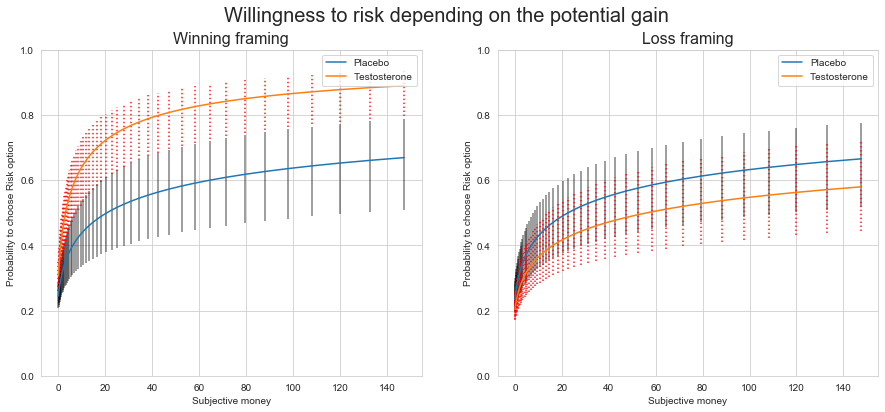

In [46]:
gaps = np.linspace(0,5,50)

risk_sens_gain(trace_6, gaps, cr_int = 0.7)